# Report 3

In this report we will be working on a classic problem: MNIST Digit Classification

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [6]:
with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    # print(data.shape) # (47040000,)
    Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)

with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytestlabels = data.reshape((size,)) # (Optional)
        

    
traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))    
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)

(784, 60000)
(60000,)
(784, 10000)
(10000,)


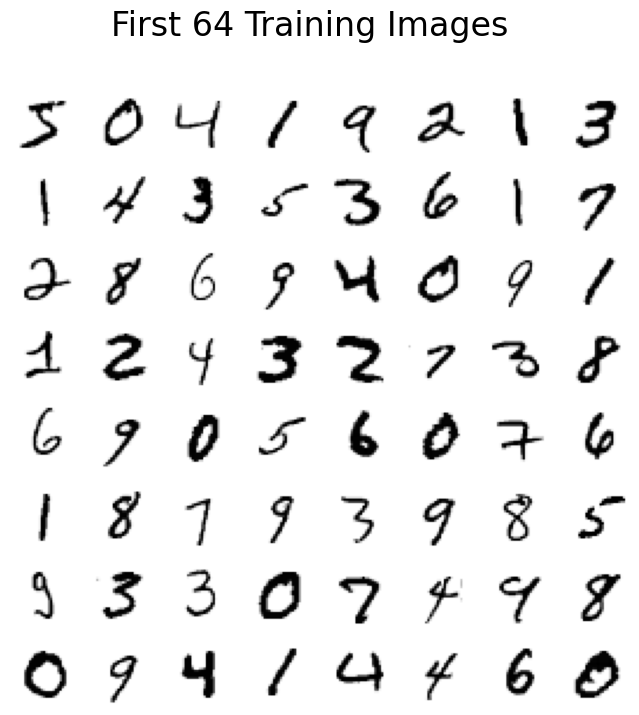

In [7]:
def plot_digits(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(Xtraindata, 8, "First 64 Training Images" )


# Task 1

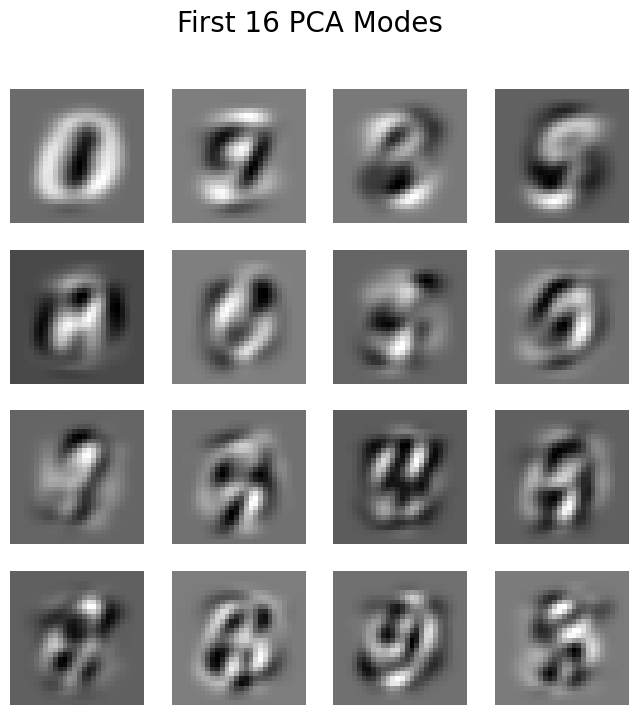

In [8]:
Xtrain = Xtraindata.T

pca = PCA()
pca.fit(Xtrain)
pc_modes = pca.components_[:16]

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        idx = i * 4 + j
        axs[i, j].imshow(pc_modes[idx].reshape(28, 28), cmap="gray")
        axs[i, j].axis("off")
fig.suptitle("First 16 PCA Modes", fontsize=20)
plt.show()


# Task 2

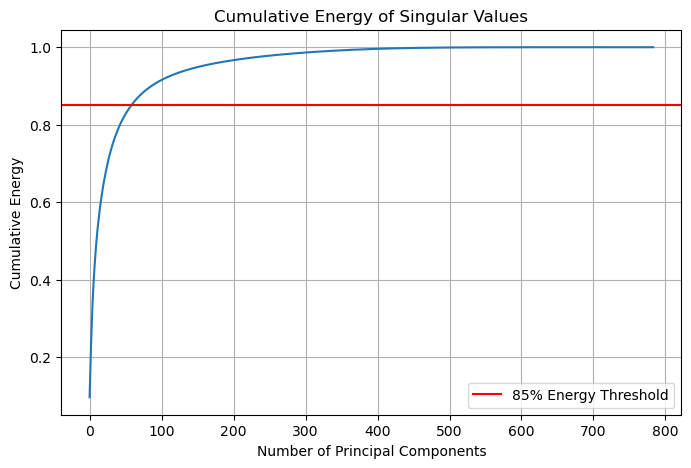

Number of PC modes needed to capture at least 85% of the energy: 59


In [9]:
Sigma = pca.singular_values_

energy = np.power(Sigma, 2) / np.sum(np.power(Sigma, 2))
cumulative_energy = np.cumsum(energy)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_energy)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Energy')
plt.title('Cumulative Energy of Singular Values')
plt.axhline(y=0.85, color='r', linestyle='-', label='85% Energy Threshold')
plt.legend()
plt.grid(True)
plt.show()


k = np.argmax(cumulative_energy >= 0.85) + 1
print("Number of PC modes needed to capture at least 85% of the energy:", k)


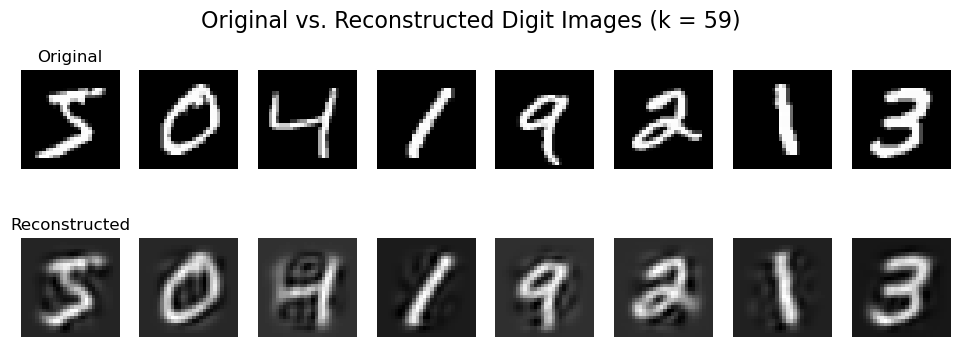

In [10]:
pca_k = PCA(n_components=k)
Xtrain_reduced = pca_k.fit_transform(Xtrain)
Xtrain_reconstructed = pca_k.inverse_transform(Xtrain_reduced)

num_images = 8
fig, axs = plt.subplots(2, num_images, figsize=(num_images * 1.5, 4))
for i in range(num_images):
    axs[0, i].imshow(Xtrain[i].reshape(28, 28), cmap="gray")
    axs[0, i].axis("off")
    if i == 0:
        axs[0, i].set_title("Original", fontsize=12)
    # Reconstructed below
    axs[1, i].imshow(Xtrain_reconstructed[i].reshape(28, 28), cmap="gray")
    axs[1, i].axis("off")
    if i == 0:
        axs[1, i].set_title("Reconstructed", fontsize=12)

fig.suptitle("Original vs. Reconstructed Digit Images (k = {})".format(k), fontsize=16)
plt.show()


## Task 3

In [11]:
def select_digits(X_train, y_train, X_test, y_test, digits):
    # Select training subset
    train_mask = np.isin(y_train, digits)
    X_subtrain = X_train[train_mask]
    y_subtrain = y_train[train_mask]
    
    # Select test subset
    test_mask = np.isin(y_test, digits)
    X_subtest = X_test[test_mask]
    y_subtest = y_test[test_mask]
    
    return X_subtrain, y_subtrain, X_subtest, y_subtest

I want to make a heatmap plot for visuals while comparing, so here's a helper function:

In [12]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

## Task 4

1 vs 8 - CV Accuracy: 0.964, Test Accuracy: 0.980
Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.99      0.98      1135
           8       0.99      0.97      0.98       974

    accuracy                           0.98      2109
   macro avg       0.98      0.98      0.98      2109
weighted avg       0.98      0.98      0.98      2109



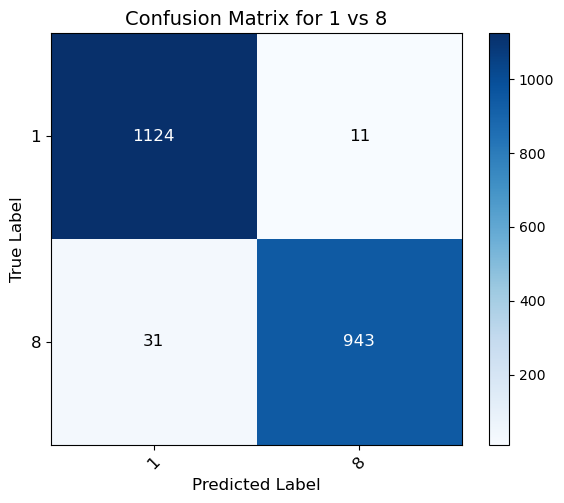

In [13]:
digits = [1, 8]
X_subtrain, y_subtrain, X_subtest, y_subtest = select_digits(Xtrain, ytrainlabels, Xtestdata.T, ytestlabels, digits)
X_subtrain_pca = pca_k.transform(X_subtrain)
X_subtest_pca = pca_k.transform(X_subtest)

ridge_clf = RidgeClassifier()
cv_scores = cross_val_score(ridge_clf, X_subtrain_pca, y_subtrain, cv=5)
ridge_clf.fit(X_subtrain_pca, y_subtrain)
test_acc = ridge_clf.score(X_subtest_pca, y_subtest)
y_pred = ridge_clf.predict(X_subtest_pca)
cm = confusion_matrix(y_subtest, y_pred)

print(f"1 vs 8 - CV Accuracy: {cv_scores.mean():.3f}, Test Accuracy: {test_acc:.3f}")
print("Classification Report:")
print(classification_report(y_subtest, y_pred))
plot_confusion_matrix(cm, classes=digits, title='Confusion Matrix for 1 vs 8')



## Task 5

3 vs 8 - CV Accuracy: 0.959, Test Accuracy: 0.964
Classification Report:
              precision    recall  f1-score   support

           3       0.96      0.97      0.96      1010
           8       0.97      0.96      0.96       974

    accuracy                           0.96      1984
   macro avg       0.96      0.96      0.96      1984
weighted avg       0.96      0.96      0.96      1984



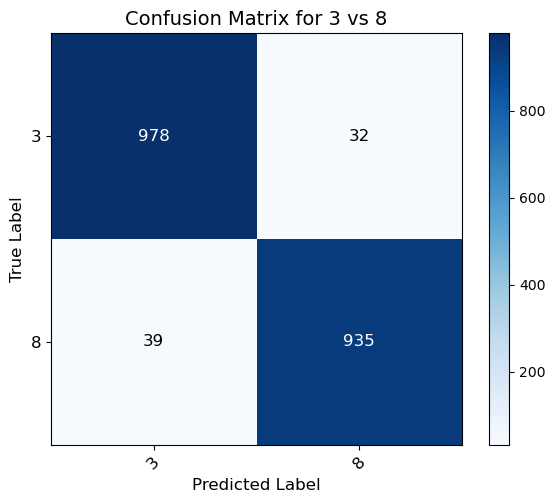

2 vs 7 - CV Accuracy: 0.980, Test Accuracy: 0.975
Classification Report:
              precision    recall  f1-score   support

           2       0.98      0.97      0.97      1032
           7       0.97      0.98      0.97      1028

    accuracy                           0.97      2060
   macro avg       0.97      0.97      0.97      2060
weighted avg       0.97      0.97      0.97      2060



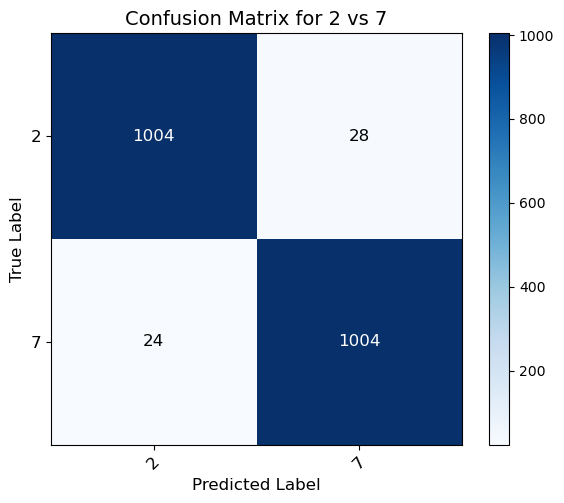

In [14]:
for pair in [[3, 8], [2, 7]]:
    X_subtrain, y_subtrain, X_subtest, y_subtest = select_digits(Xtrain, ytrainlabels, Xtestdata.T, ytestlabels, pair)
    X_subtrain_pca = pca_k.transform(X_subtrain)
    X_subtest_pca = pca_k.transform(X_subtest)
    
    ridge_clf = RidgeClassifier()
    cv_scores = cross_val_score(ridge_clf, X_subtrain_pca, y_subtrain, cv=5)
    ridge_clf.fit(X_subtrain_pca, y_subtrain)
    test_acc = ridge_clf.score(X_subtest_pca, y_subtest)
    y_pred = ridge_clf.predict(X_subtest_pca)
    cm = confusion_matrix(y_subtest, y_pred)
    
    print(f"{pair[0]} vs {pair[1]} - CV Accuracy: {cv_scores.mean():.3f}, Test Accuracy: {test_acc:.3f}")
    print("Classification Report:")
    print(classification_report(y_subtest, y_pred))
    plot_confusion_matrix(cm, classes=pair, title=f'Confusion Matrix for {pair[0]} vs {pair[1]}')


## Task 6

Ridge (Multi-class) - CV Accuracy: 0.844, Test Accuracy: 0.856
KNN (Multi-class) - CV Accuracy: 0.975, Test Accuracy: 0.976


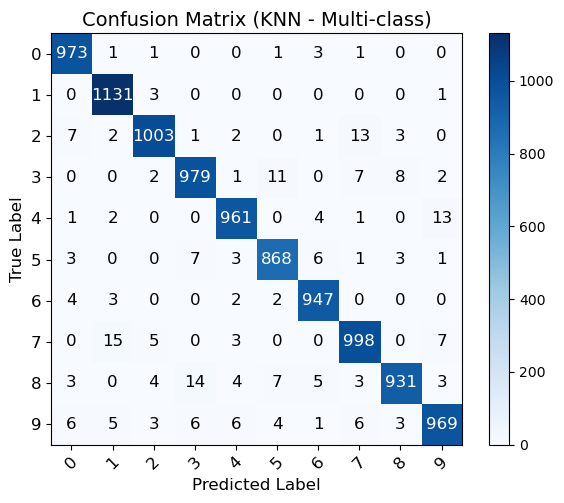

In [ ]:
Xtrain_pca = pca_k.transform(Xtrain)
Xtest_pca = pca_k.transform(Xtestdata.T)

# Ridge Classifier (Multi-class)!!
ridge = RidgeClassifier()
ridge_cv = cross_val_score(ridge, Xtrain_pca, ytrainlabels, cv=5)
ridge.fit(Xtrain_pca, ytrainlabels)
ridge_acc = ridge.score(Xtest_pca, ytestlabels)
print(f"Ridge (Multi-class) - CV Accuracy: {ridge_cv.mean():.3f}, Test Accuracy: {ridge_acc:.3f}")

# KNN Classifier (Multi-class)!!
knn = KNeighborsClassifier(n_neighbors=5)
knn_cv = cross_val_score(knn, Xtrain_pca, ytrainlabels, cv=5)
knn.fit(Xtrain_pca, ytrainlabels)
knn_acc = knn.score(Xtest_pca, ytestlabels)
print(f"KNN (Multi-class) - CV Accuracy: {knn_cv.mean():.3f}, Test Accuracy: {knn_acc:.3f}")

y_pred_knn = knn.predict(Xtest_pca)
cm_multi = confusion_matrix(ytestlabels, y_pred_knn)
classes = np.unique(ytestlabels)
plot_confusion_matrix(cm_multi, classes=classes, title='Confusion Matrix (KNN - Multi-class)')

## Bonus Question

In [16]:
print(f"Ridge Test Accuracy: {ridge_acc:.3f}")
print(f"KNN   Test Accuracy: {knn_acc:.3f}")


Ridge Test Accuracy: 0.856
KNN   Test Accuracy: 0.976
